In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = 'python'

In [2]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from utils import *
from model import *

Using TensorFlow backend.
d:\code\Attention-CLX-stock-prediction\.venv\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data1 = pd.read_csv("./601988.SH.csv")
data1.index = pd.to_datetime(data1['trade_date'], format='%Y%m%d')
#data1 = data1.drop(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pb', 'total_share', 'float_share', 'free_share'], axis=1)
data1 = data1.loc[:, ['open', 'high', 'low', 'close', 'vol', 'amount']]
data_yuan = data1
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
data1 = pd.merge(data1, residuals, on='trade_date')
data = data1.iloc[1:3500, :] 
data2 = data1.iloc[3500:, :] 

(7, 2)
# [[ 2.46000000e+00  7.40000000e+00]
 [ 2.46000000e+00  7.58000000e+00]
 [ 2.44000000e+00  7.23000000e+00]
 [ 2.45000000e+00  7.48000000e+00]
 [ 5.67951900e+04  5.10989742e+07]
 [ 1.57377550e+04  2.74651219e+07]
 [-5.51106112e-01  4.98073058e-01]]
(3478, 20, 7) (3478, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 7)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 64)       512         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 20, 64)       0           conv1d_1[0][0]                   
___________

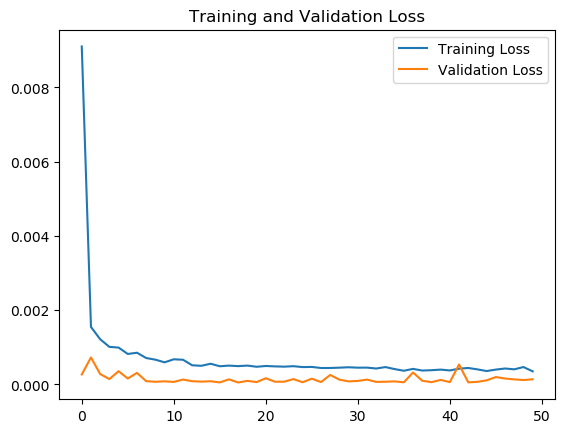

In [4]:
TIME_STEPS = 20

data, normalize = NormalizeMult(data)
print('#', normalize)
pollution_data = data[:, 3].reshape(len(data), 1)

train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

print(train_X.shape, train_Y.shape)

m = attention_model(INPUT_DIMS=7)
m.summary() 
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./stock_model.h5")
np.save("stock_normalize.npy", normalize)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Index(['open', 'high', 'low', 'close', 'vol', 'amount', '0'], dtype='object')
(7, 2)
testX Y shape is: (159, 20, 7) (159, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 7)        0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 20, 64)       512         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 20, 64)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 20, 128)      66048       d

d:\code\Attention-CLX-stock-prediction\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\code\Attention-CLX-stock-prediction\.venv\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


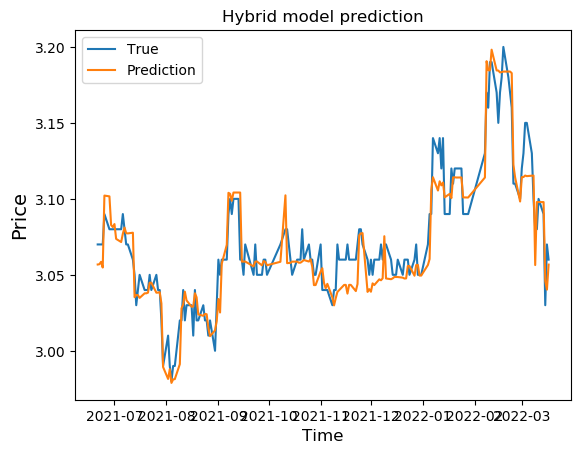

In [5]:
class Config:
    def __init__(self):
        self.dimname = 'close'

config = Config()
name = config.dimname
# normalize = np.load("normalize.npy")
y_hat, y_test = PredictWithData(data2, data_yuan, name, 'stock_model.h5',7)
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test,y_hat)
time = pd.Series(data1.index[3499:])
plt.plot(time, y_test, label='True')
plt.plot(time, y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()